In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(1, .1, size=n)
phat0 = g*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#wakeup rates
gamma =  sts.expon.rvs(loc=1,scale=5, size=n)

#holdings fiat
h = sts.expon.rvs( loc=10,scale=10, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

(array([36., 17., 14., 12.,  6.,  3.,  7.,  2.,  2.,  1.]),
 array([ 1.0319341 ,  2.96150724,  4.89108039,  6.82065354,  8.75022669,
        10.67979984, 12.60937299, 14.53894614, 16.46851929, 18.39809244,
        20.32766559]),
 <a list of 10 Patch objects>)

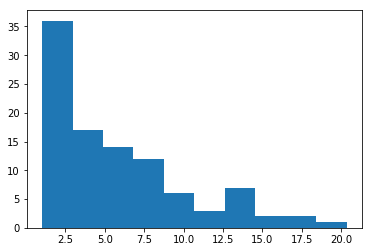

In [4]:
plt.hist(gamma)

In [5]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'rates':[1/gamma],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust]}

In [6]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'actions': {}}

In [7]:
initial_conditions

{'actions': {},
 'funds': 50000.0,
 'holdings': array([11.05986715, 14.94218419, 15.48820511, 12.92408422, 16.44058258,
        10.04330453, 10.1363183 , 11.25295092, 23.30880776, 15.84820996,
        19.32519009, 30.84642311, 28.6472968 , 22.62088499, 55.7532467 ,
        14.53069067, 19.69148971, 16.03173292, 14.26035724, 12.50119405,
        17.18948811, 25.17606952, 34.37364318, 11.21207026, 10.85120593,
        16.83190876, 11.02032996, 28.55606449, 15.97294022, 18.35775853,
        10.20455263, 14.9005508 , 10.14350217, 32.71292419, 28.66446322,
        52.09840552, 31.14302571, 24.96256575, 16.82618473, 12.08821128,
        19.80327803, 17.56324532, 18.97653665, 26.4598746 , 13.95149808,
        34.51432315, 18.72391548, 16.71876591, 18.13080429, 14.53424435,
        15.379136  , 12.53012723, 10.30743761, 19.41545118, 23.93423996,
        26.64819375, 25.59097769, 26.9389408 , 68.286046  , 13.37039963,
        22.98591204, 21.70571029, 15.73671593, 19.62997574, 19.69963393,
    

In [8]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    if delF <1:
        if s['funds'] <1000:
            delF =100
    
    return({'delF':delF})

In [9]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [10]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [11]:
#change in F (revenue and spending accounted for)
def choose_agents(params, step, sL, s):
    n = params['population']
    rates = params['rates']
    
    agents = []
    for a in range(n):
        sq_gap = (s['spot_price']-s['prices'][a])**2
        pr = (rates[a]+sq_gap)/(1+sq_gap) #rates when sq_gap =0, 1 when sq_gap -> infty
        rv = np.random.rand()
        if rv < pr:
            agents.append(a)
    
    #shuffle
    shuffled_agents =np.random.choice(agents,len(agents), False)     
        
    return({'agents':shuffled_agents})

In [12]:
def agent_actions(params, step, sL, s, _input):
    
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    P=s['spot_price']
    
    actions = []
    for a in _input['agents']:
        h_a = s['holdings'][a]
        phat_a = s['prices'][a]
        s_a =  s['tokens'][a]
        beta = params['beta']

        if P>phat_a: #equiv: pbar(0)>phat_a
            mech = 'burn'
                        
            #approx for burn s.t. p=phat
            #armijo style
            amt = s_a
            
            def pbar(amt):
                output = withdraw_with_tax(amt, R,S, V0, params['phi'], params['kappa'])

                if not(output[2])>0:
                    return np.Infinity
                else:
                    return output[2]

            if amt > 10**-8:
                while pbar(amt)< phat_a:
                    amt = amt*beta

        else: # P<phat_a; #equiv pbar(0)<phat_a
            mech = 'bond'
            #approx for buy s.t. p=phat
            #armijo style
            amt = h_a
  
            def pbar(amt):
                output = mint(amt, R,S, V0, params['kappa'])

                if not(output[1])>0:
                    return 0
                else:
                    return output[1]
                
            if amt > params['dust']:
                while pbar(amt)> phat_a:
                    amt = amt*beta
        
        action = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
        
        if action['mech'] == 'bond':
            h_a = h_a-amt
            dS, pbar = mint(amt, R,S, V0, params['kappa'])
            R = R+amt
            S = S+dS
            s_a = s_a+dS
            P = spot_price(R, V0, kappa)
    
        elif action['mech'] == 'burn':
            s_a = s_a-amt
            dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
            R = R-dR
            F = F + params['phi']*dR
            S = S-amt
            h_a = h_a + (1-params['phi'])*dR
            P = spot_price(R, V0, kappa)
        
        action['posterior'] = {'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a}
        actions.append(action)
        
    key = 'actions'
    value = actions
    
    return (key, value)

In [13]:
def resolve_actions(params, step, sL, s):
    
    H_a = s['holdings']
    S_a =  s['tokens']
    
    actions = s['actions']
    
    for action in actions:
        a= action['agent']
        H_a[a] = action['posterior']['h_a']
        S_a[a] = action['posterior']['s_a']
    
    #last action only
    F = action['posterior']['F']
    R = action['posterior']['R']
    P = action['posterior']['P']
    S = action['posterior']['S']
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'S_a':S_a, 'H_a':H_a})

In [14]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    H_a = _input['H_a']
    
    key = 'holdings'
    value = H_a
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    S_a = _input['S_a']
    
    sumS = np.sum(S_a)
    S = _input['S']
    
    tokens = S_a*S/sumS
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agents
        },
        'variables': { 
            'actions': agent_actions, 
        }
    },
    {
      'policies': {
          'act': resolve_actions,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [16]:
time_periods_per_run = 500
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [17]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 500), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([1.30049726, 0.98470691, 1.05321633, 0.96939095, 0.92544539,
       1.01425588, 1.0228024 , 0.78703228, 0.94179167, 0.96385964,
       0.87208454, 0.94244219, 1.09071831, 1.0129536 , 0.90773756,
       0.89742438, 1.00544415, 1.07848972, 1.15337594, 0.93280853,
       0.86127553, 1.01259862, 0.96948019, 0.84862713, 1.08636476,
       1.06924922, 1.02109687, 0.92102105, 0.94157513, 1.01842161,
       0.89239949, 0.98074385, 0.91951177, 1.14954805, 0.95942784,
       1.03902388, 0.97795167, 1.15033743, 0.99352293, 0.95973281,
       1.06808185, 0.85184633, 0.86827154, 1.07317232, 1.04810033,
       1.1932734 , 0.9403552 , 0.83868956, 0.86404574, 0.95900389,
       0.84336007, 1.18176877, 1.01165514, 0.97462265, 0.95379659,
       0.98253086, 0.84844908, 0.98172198, 1.04061565, 1.08848738,
       1.07511908, 1.02302204, 1.07963931, 0.75804473, 1.13699112,
       0.92168365, 1.11895939, 0.90671204, 0.930272  , 1.

In [18]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [19]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a19c50240>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a19c50240>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS


In [20]:
experiment_index = 0
df = results[experiment_index]['result']

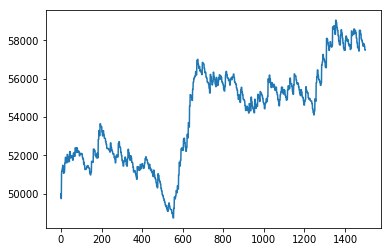

In [21]:
df.funds.plot()

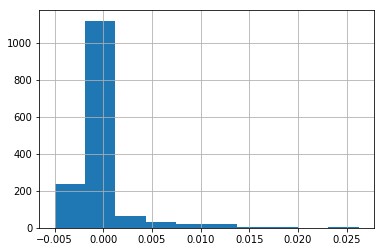

In [22]:
(df.funds.diff()/df.funds).hist()

In [23]:
rdf = df[df.substep == 3].copy()

In [24]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

In [25]:
rdf['holding_wts'] = (rdf.holdings/rdf.holdings.apply(sum))
rdf['h_wt_mean_price'] = (rdf.holding_wts*rdf.prices).apply(sum)

In [26]:
rdf['wealth'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [27]:
rdf['wealth_wts'] = rdf.wealth/rdf.wealth.apply(sum)
rdf['w_wt_mean_price'] = (rdf.wealth_wts*rdf.prices).apply(sum)

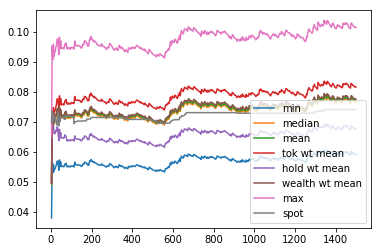

In [28]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

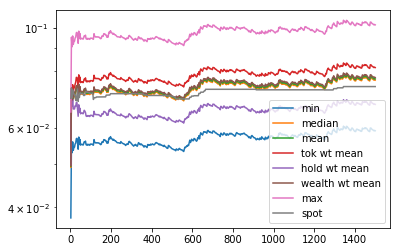

In [29]:
rdf.prices.apply(np.min).plot(logy=True)
rdf.prices.apply(np.median).plot(logy=True)
rdf.prices.apply(np.mean).plot(logy=True)
rdf.wt_mean_price.plot(logy=True)
rdf.h_wt_mean_price.plot(logy=True)
rdf.w_wt_mean_price.plot(logy=True)
rdf.prices.apply(np.max).plot(logy=True)
rdf.spot_price.plot(logy=True)
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [30]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

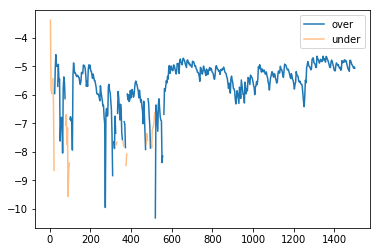

In [31]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [32]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

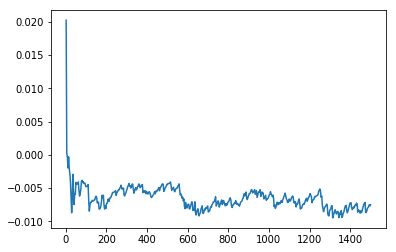

In [33]:
rdf.est_err.plot()

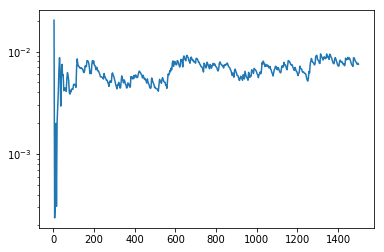

In [34]:
rdf.est_err.apply(np.abs).plot(logy=True)

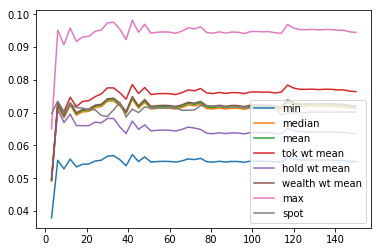

In [35]:
#head T
T = 50
rdf.head(T).prices.apply(np.min).plot()
rdf.head(T).prices.apply(np.median).plot()
rdf.head(T).prices.apply(np.mean).plot()
rdf.head(T).wt_mean_price.plot()
rdf.head(T).h_wt_mean_price.plot()
rdf.head(T).w_wt_mean_price.plot()
rdf.head(T).prices.apply(np.max).plot()
rdf.head(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

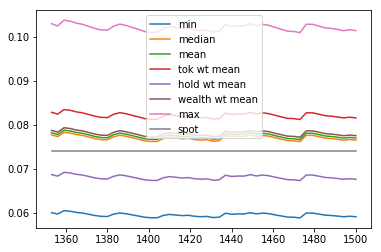

In [36]:
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).h_wt_mean_price.plot()
rdf.tail(T).w_wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [37]:
tx_data = rdf.actions.values
transactions = []
states = []
for t in range(time_periods_per_run):
    for tx in range(len(tx_data[t])):
        states.append(tx_data[t][tx]['posterior'])
        transactions.append(tx_data[t][tx])


In [38]:
sdf = pd.DataFrame(states)
tdf = pd.DataFrame(transactions).drop('posterior', axis=1)

In [39]:
tdf.head()

agent          amt  mech      pbar
0     67  5944.118713  burn  0.094718
1     94  5385.770251  burn  0.094179
2     98  9158.190387  burn  0.093489
3     50  7904.758973  burn  0.092678
4     70  9292.069223  burn  0.091861

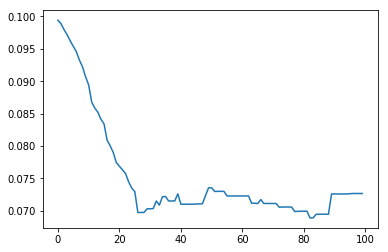

In [40]:
sdf['P'].head(100).plot()

In [41]:
bond_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='bond']
burn_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='burn']

(array([197.,   6.,   7.,   5.,   3.,   0.,   1.,   0.,   1.,   1.]),
 array([   0.        ,  222.28881809,  444.57763618,  666.86645427,
         889.15527236, 1111.44409045, 1333.73290854, 1556.02172663,
        1778.31054472, 2000.59936281, 2222.8881809 ]),
 <a list of 10 Patch objects>)

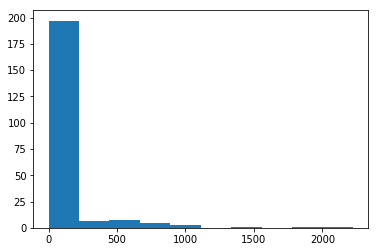

In [42]:
plt.hist(bond_amts)

(array([219.,  24.,  19.,   8.,   4.,   2.,   0.,   1.,   1.,   1.]),
 array([    0.        ,  3240.1230237 ,  6480.24604741,  9720.36907111,
        12960.49209481, 16200.61511851, 19440.73814222, 22680.86116592,
        25920.98418962, 29161.10721333, 32401.23023703]),
 <a list of 10 Patch objects>)

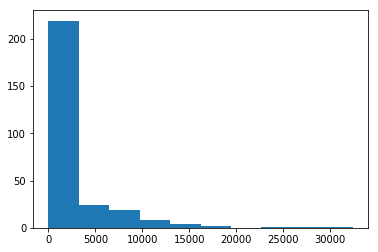

In [43]:
plt.hist(burn_amts)

In [44]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

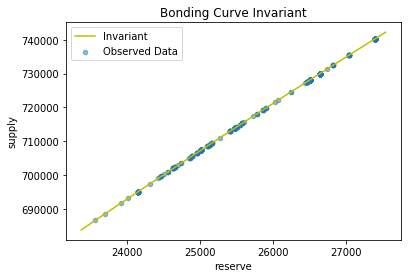

In [45]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

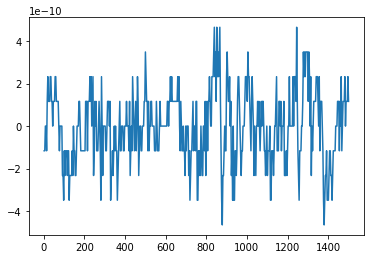

In [46]:
(rdf.tokens.apply(sum)-rdf.supply).plot()

In [47]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

(array([71.,  5.,  9.,  8.,  1.,  4.,  1.,  0.,  0.,  1.]),
 array([   0.        ,  225.91666347,  451.83332693,  677.7499904 ,
         903.66665387, 1129.58331733, 1355.4999808 , 1581.41664427,
        1807.33330773, 2033.2499712 , 2259.16663466]),
 <a list of 10 Patch objects>)

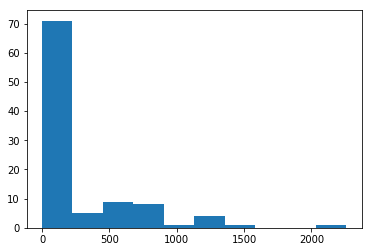

In [48]:
plt.hist(rdf.iloc[-1].holdings)

In [49]:
rdf['gini_h'] = rdf.holdings.apply(gini)

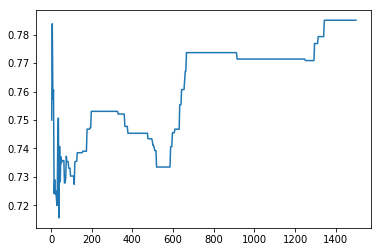

In [50]:
rdf.gini_h.plot()

(array([29., 12., 26., 14.,  9.,  4.,  4.,  0.,  1.,  1.]),
 array([    0.        ,  3129.07337115,  6258.1467423 ,  9387.22011346,
        12516.29348461, 15645.36685576, 18774.44022691, 21903.51359807,
        25032.58696922, 28161.66034037, 31290.73371152]),
 <a list of 10 Patch objects>)

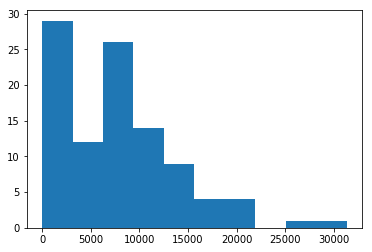

In [51]:
plt.hist(rdf.iloc[-1].tokens)

In [52]:
rdf['gini_s'] = rdf.tokens.apply(gini)

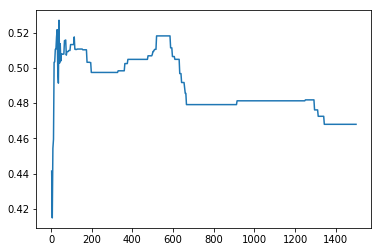

In [53]:
rdf.gini_s.plot()

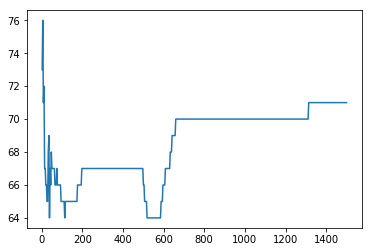

In [54]:
rdf.tokens.apply(np.count_nonzero).plot()

In [55]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

(array([42., 22., 13.,  7.,  8.,  5.,  0.,  0.,  1.,  2.]),
 array([ 374.03166522,  568.24101061,  762.450356  ,  956.65970138,
        1150.86904677, 1345.07839216, 1539.28773755, 1733.49708293,
        1927.70642832, 2121.91577371, 2316.1251191 ]),
 <a list of 10 Patch objects>)

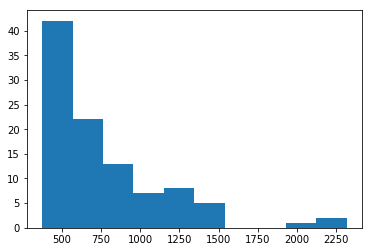

In [56]:
plt.hist(rdf.iloc[-1].asset_value)

In [57]:
rdf['gini'] = rdf.asset_value.apply(gini)

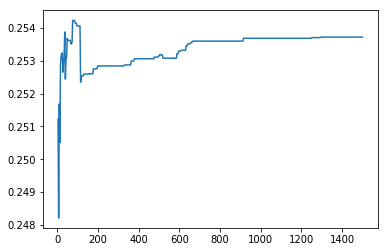

In [58]:
rdf.gini.plot()